<a href="https://colab.research.google.com/github/caangonz/Py4EO/blob/main/Practical5_SAR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Practical 5: Multi-temporal SAR image analysis for urban land monitoring using GEE
Carlos Gonzales Inca & Niina Käyhkö

# Task 1. Browsing Sentinel 1 Data in GEE

In [ ]:
# Start Google Earth Engine
import ee

In [ ]:
# Trigger the authentication flow.
ee.Authenticate()

True

In [ ]:
# Start ee system.
ee.Initialize(project='COPY YOUR PROJECT ID FROM GEE')

In [ ]:
# Define a study area polygon, e.g., get coordinates from
# geojson.io

ROI = ee.Geometry.Polygon([
            [
              39.172268551750875,
              -6.0644125791034185
            ],
            [
              39.1735243597177,
              -6.257938403738862
            ],
            [
              39.280895940871716,
              -6.257314239045414
            ],
            [
              39.280895940871716,
              -6.063163795331832
            ],
            [
              39.172268551750875,
              -6.0644125791034185
            ]
          ])

In [ ]:
# Load the Sentinel-1 ImageCollection.
S1 = ee.ImageCollection('COPERNICUS/S1_GRD')\
        .filterBounds(ROI)\
        .filterDate('2023-04-01', '2023-09-30')

In [ ]:
S1

# TASK 2. Reduce SAR image noisennes by tempral averaging and spatial spckel filtering

In [ ]:
# Filter by metadata properties.
# Filter interferometric wide (IW) swath mode images
# and ASCENDING adquisition
S1_Asc = S1.filter(ee.Filter.eq('instrumentMode', 'IW'))\
          .filter(ee.Filter.eq('orbitProperties_pass', 'ASCENDING'))
          #.filter(ee.Filter.eq('relativeOrbitNumber_start', 57))


In [ ]:
S1_Asc

In [ ]:
S1_Asc

In [ ]:
# Visualise ascending images
S1_Asc_list = S1_Asc.toList(S1_Asc.size());
img_a = ee.Image(S1_Asc_list.get(0));
VV_HH = img_a.select('VV').subtract(img_a.select('VH')).rename('VV_VH');
img_a_rgb = img_a.addBands(VV_HH)

In [ ]:
#var img_rgb2 = ee.Image.rgb(img.select('VV'),img.select('VH'),img.select('VV_VH'))
img_a_rgb

In [ ]:
# Estimate median of multitemporal SAR images
# ASCENDING MEDIAN
S1_Asc_median = S1_Asc.median()
VV_VH_med_asc = S1_Asc_median.select('VV').subtract(S1_Asc_median.select('VH')).rename('VV_VH')
S1_Asc_median_rgb = S1_Asc_median.addBands(VV_VH_med_asc).select('VV','VH','VV_VH').clip(ROI)

In [ ]:
S1_Asc_median_rgb

In [ ]:
# Pass spatial filter and Clip for the study area
#S1_Asc_median_filter = S1_Asc_median_rgb.focalMedian(30, 'circle','meters')

In [ ]:
# Install geemap for interactive image visualization
#!pip install geemap

In [ ]:
import geemap

In [ ]:
poi = ROI.centroid() # get the centroid coordinate of the study area
poi

In [ ]:
# Visualize the map
Map = geemap.Map(center= [-6.16,39.23], zoom= 8);
url = 'https://mt1.google.com/vt/lyrs=y&x={x}&y={y}&z={z}' # Add google satellite image
Map.add_tile_layer(url, name='Google Satellite', attribution='Google')
Map.addLayer(S1_Asc_median_rgb,{'bands':['VV','VH','VV_VH'],'min': [-20, -20, 0], 'max': [0, 0, 8]},'S1_Asc_median_rgb')
Map.addLayerControl();
Map

Map(center=[-6.16, 39.23], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGU…

# TASK 3. Generate training samples for SAR images classification

In [ ]:
# Generate sampling data using ESA land cover data
# https://worldcover2020.esa.int/data/docs/WorldCover_PUM_V1.1.pdf

lc = ee.Image('ESA/WorldCover/v100/2020').clip(ROI) # ESA WorldCover land cover
lc

In [ ]:
Old = [10, 20, 30, 40, 50, 60, 70, 80, 90, 95, 100]
New = [1,2,3,4,5,6,7,8,9,10,11]
lc2 = lc.remap(Old, New).rename('lc_class').toByte() # reclass

lc_palette = [
  'green', # 1, Tree cover
  'orange', #2,  Shrubland
  'yellow', #3,  Grassland
  'pink', # 4, Cropland
  'black', # 5, Built-up
  'gray', # 6,  Bare and sparse vegetation
  'white', # 7, snow and ice
  'blue', # 8, water bodies
  'cyan', # 9, wetland
  'olive', # 10, Mangroves
  'brown' #11, Moss and lichen
  ]

In [ ]:
Map.addLayer(lc2, {'palette':lc_palette, 'min':1, 'max':11}, 'ESA LCLU');
Map

In [ ]:
# Create training samples for SAR images classification
My_samples = S1_Asc_median_rgb.addBands(lc2).stratifiedSample(
  numPoints = 800,
  classBand= 'lc_class',
  region = ROI,
  scale = 10,
  geometries = True
)

In [ ]:
My_samples

In [ ]:
Map.addLayer(My_samples.draw('red'),{},'My ESA LCLU samples')
Map

In [ ]:
# Export to your Google drive the samples, to plot spectral profile and spectral separability evaluation
task = ee.batch.Export.table.toDrive(
  collection = My_samples,
  description = 'my_LU_samples2',
  fileFormat= 'CSV'
  );
task.start()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
import pandas as pd

In [ ]:
lc_samples = pd.read_csv('/content/drive/MyDrive/My_SAR_samples.csv')

In [ ]:
lc_samples

,system:index,VH,VV,VV_VH,angle,lc_class,.geo
0,0,-14.502978,-7.400450,0.478461,40.516430,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
1,1,-14.323270,-7.473344,0.535170,40.291550,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
2,2,-14.092015,-4.383037,0.317522,40.548650,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
3,3,-14.651363,-8.671238,0.581217,40.563835,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
4,4,-15.105430,-7.623732,0.487150,40.485447,1,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
...,...,...,...,...,...,...,...
7195,7195,-15.011024,-8.020412,0.556206,40.220320,10,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7196,7196,-15.378792,-8.433977,0.545370,40.226917,10,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7197,7197,-13.764248,-8.712483,0.629336,40.187134,10,"{""geodesic"":false,""type"":""Point"",""coordinates""..."
7198,7198,-15.269604,-9.235868,0.612510,40.550804,10,"{""geodesic"":false,""type"":""Point"",""coordinates""..."


<Axes: xlabel='VV', ylabel='VH'>

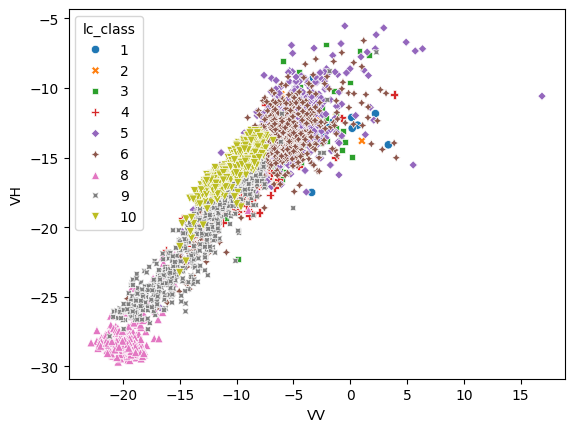

In [ ]:
# Scatter plot
# Color palette dictionary
colors = sns.color_palette("tab10")

# Create scatterplot
sns.scatterplot(data = lc_samples, x="VV", y="VH", hue="lc_class", style = "lc_class",palette = colors)

In [ ]:
lc_samples2 = lc_samples[['VH','VV','VV_VH','lc_class']]

In [ ]:
lc_samples2_long = pd.melt(lc_samples2, id_vars='lc_class', value_vars=['VV', 'VH'],
             var_name='polarization', value_name='backscatter')

In [ ]:
lc_samples2_long

,lc_class,polarization,backscatter
0,1,VV,-7.400450
1,1,VV,-7.473344
2,1,VV,-4.383037
3,1,VV,-8.671238
4,1,VV,-7.623732
...,...,...,...
14395,10,VH,-15.011024
14396,10,VH,-15.378792
14397,10,VH,-13.764248
14398,10,VH,-15.269604


<Axes: xlabel='polarization', ylabel='backscatter'>

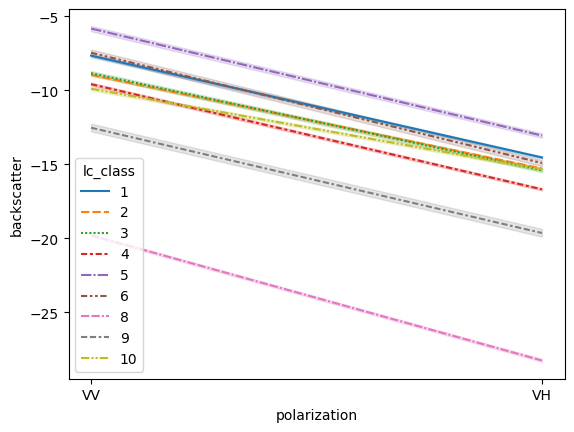

In [ ]:
sns.lineplot(data=lc_samples2_long, x="polarization", y="backscatter", hue="lc_class",style = "lc_class",palette = colors)

<Axes: xlabel='lc_class', ylabel='backscatter'>

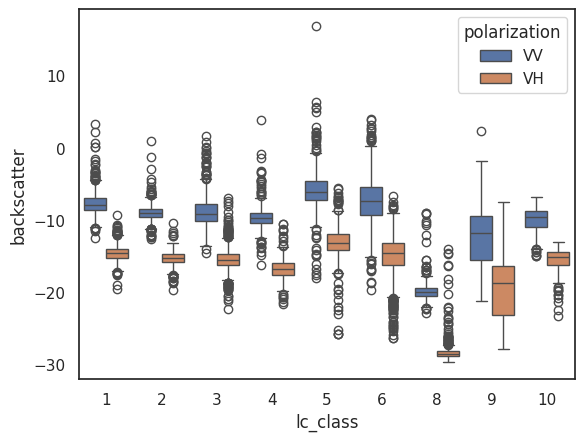

In [ ]:
sns.set_theme(style="white")
sns.boxplot(data = lc_samples2_long, x="lc_class", y="backscatter", hue="polarization")

Text(0.5, 1, 'LCLU SAR samples')

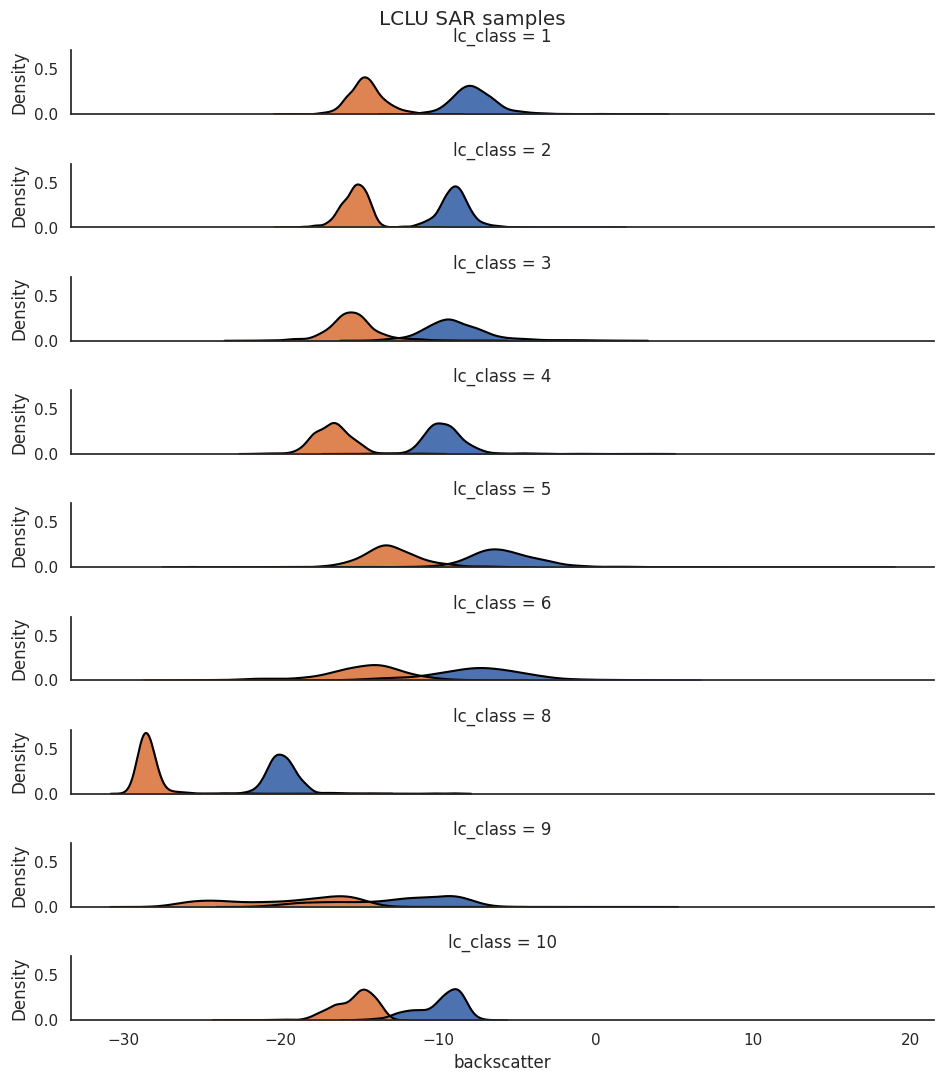

In [ ]:
sns.set_theme(style="white")
g = sns.FacetGrid(lc_samples2_long,  row="lc_class", hue="polarization", aspect= 8, height=1.2)
g.map_dataframe(sns.kdeplot, x="backscatter", fill=True, alpha=1) # kernel density plot ("kdeplot")
g.map_dataframe(sns.kdeplot, x="backscatter", color='black')
plt.suptitle('LCLU SAR samples', y=1)